# Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
from typing import Tuple, List
# Set the style for a professional, publication-quality look
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['font.family'] = 'Times New Roman'
import time

# Read Data and Preprocessing

### Sentinel 2 Data

Sentinel 2 is a satellite mission developed by the European Space Agency as part of the Copernicus Programme to perform terrestrial observations in support of services such as forest monitoring, land cover changes detection, and natural disaster management. Data was download from Google Earth Engine into a CSV file. For code (JavaScript)  to download data from Google Earth Engine, please refer to the following [Link](https://code.earthengine.google.com/4efa7ed9e02667a640984aa3abf3fa3a) (My Google Earth Engine Account).

In [2]:
# Define the path to the data
path_s2 = "Satellite_Data.csv"

# Load the data
df_s2 = pd.read_csv(path_s2)

# Define the date as datetime and set it as index
df_s2['date'] = pd.to_datetime(df_s2['date'])
df_s2.set_index('date', inplace=True)

# Drop ',' from data
df_s2 = df_s2.replace(',','', regex=True)

# Convert data to float
df_s2 = df_s2.astype(float)

# Scale the data 0.0001
df_s2 = df_s2 * 0.0001

# Drop the values <0.6 and fill linearly
df_s2 = df_s2[df_s2 < 0.25]

# Fill the missing values linearly
df_s2 = df_s2.interpolate(method='linear', axis=0)

# Convert the jump date to datetime
jump_date = pd.to_datetime('2022-01-24')

# Function to adjust values after the jump
def adjust_values(df):
    # Find the last date before or on the jump date
    last_date_before_jump = df.index[df.index <= jump_date].max()
    
    # Find the first date after the jump date
    first_date_after_jump = df.index[df.index > jump_date].min()
    
    if pd.isnull(last_date_before_jump) or pd.isnull(first_date_after_jump):
        print(f"Unable to find suitable dates around {jump_date}")
        return df
    
    print(f"Adjusting based on dates: {last_date_before_jump} and {first_date_after_jump}")
    
    # Calculate the change for each column
    changes = df.loc[first_date_after_jump] - df.loc[last_date_before_jump]
    
    # Adjust all values after the jump date
    df.loc[df.index > last_date_before_jump] = df.loc[df.index > last_date_before_jump] - changes
    
    return df

# Apply the adjustment to both datasets
df_s2 = adjust_values(df_s2)

# drop duplicates
df_s2 = df_s2[~df_s2.index.duplicated(keep='first')]

# Extarpolate the data to daily
df_s2 = df_s2.resample('D').asfreq()
df_s2 = df_s2.interpolate(method='linear')


# Rename the columns by dictionary
col_dict = {'B2': 'Blue', 'B3': 'Green', 'B4': 'Red', 'B5':'RedEdge_703', 'B6': 'RedEdge_740', 'B7':'RedEdge_780', 'B8':'NIR', 'B8A':'RedEdge_865', 'B11':'SWIR_1610', 'B12':'SWIR_2100'}
df_s2.rename(columns=col_dict, inplace=True)

Adjusting based on dates: 2022-01-10 00:00:00 and 2022-01-30 00:00:00


### Sentinel 2 Data

Read the data from the CSV file

In [3]:
# Import the water station data
df_co2 = pd.read_csv(r"CO2_Flux_Data.csv")

# Set time column to datetime
df_co2['time'] = pd.to_datetime(df_co2['time'])

# time column to datetime
df_co2 = df_co2.set_index('time')

# resample the data to daily frequency
df_co2 = df_co2.resample('D').mean()

# Convert the CO2 units from umol/m2/s to g/m2/day
molar_mass_co2 = 44.01 # g/mol
seconds_per_day = 86400 # s/day
umol_to_g = molar_mass_co2 / 1e6
# df_co2 = df_co2 * umol_to_g * seconds_per_day


# Get the start and end dates of the data
start_date,end_date = df_co2.index[0].date(),df_co2.index[-1].date()

print(f"CO2 data starts at {start_date} and ends at {end_date}")

CO2 data starts at 2021-05-26 and ends at 2024-06-20


### Merge CO2 and Sentinel 2 Data into a single DataFrame

Number of missing values in water data: 52
Shape of merged water data: (990, 11)


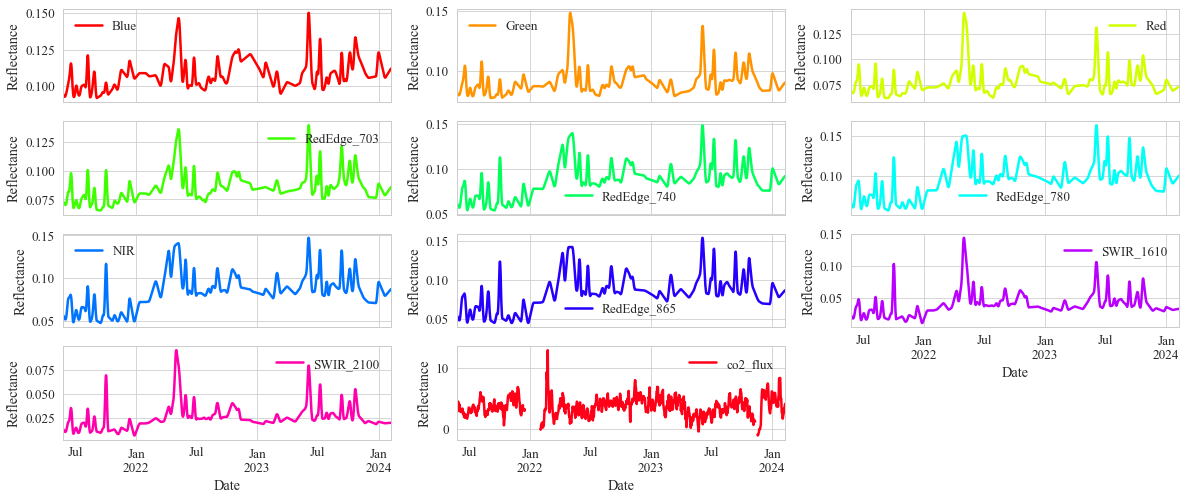

In [4]:
# Cut the dataframes to the same time period based on the start and end dates
df_s2 = df_s2.loc[start_date:end_date]

# Merge the dataframes for each type of data
data = pd.merge(df_s2, df_co2, left_index=True, right_index=True, how='left')

# Set the index to datetime
data.index = pd.to_datetime(data.index)

# Smooth the data based on a rolling window mean of 5 days
data = data.rolling(window=5, center=True, min_periods=3).mean()

# count the number of missing values
print(f"Number of missing values in water data: {data.isnull().sum().sum()}")

# Drop the missing values
merged_water = data.dropna()

# Drop values with co2_flux < -20
# merged_water = merged_water[merged_water['co2_flux'] > -20]

# Print the shape of the merged dataframes
print(f"Shape of merged water data: {data.shape}")

# Define y label to the last plot
axes = data.plot(figsize=(20, 10), grid=True,  xlabel='Date', colormap='hsv', legend=True, subplots=True, layout=(5, 3),ylabel='Reflectance')
axes[3, 2].set_ylabel('CO2 Flux (g/m2/day)')
plt.show()

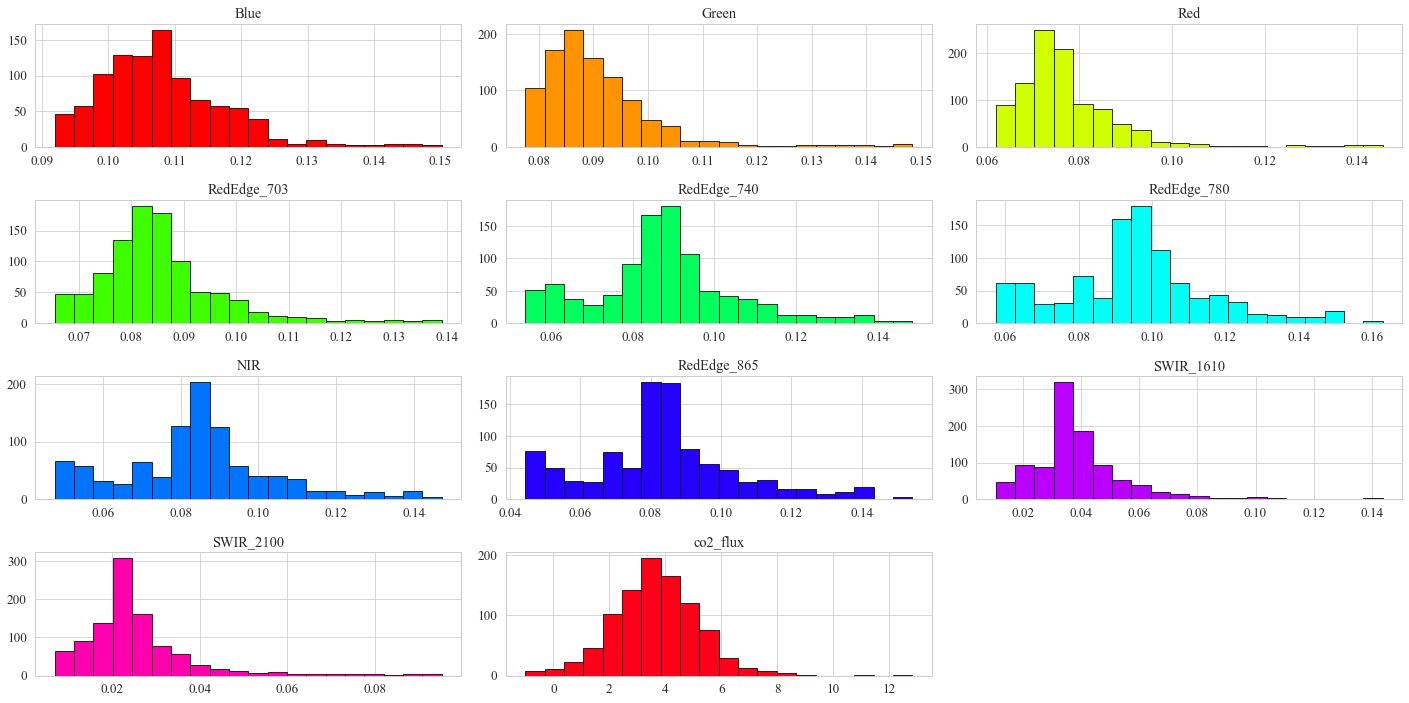

In [5]:
# Create 5*3 subplots and plot histograms
fig, axes = plt.subplots(4, 3, figsize=(20, 10))
colors = plt.cm.hsv(np.linspace(0, 1, len(data.columns)))  # Generate colors from hsv colormap

for i, ax in enumerate(axes.flat):
    if i < len(data.columns):
        data.hist(column=data.columns[i], bins=20, ax=ax, color=colors[i], edgecolor='black')
        ax.set_title(data.columns[i])
# drop the last subplot
fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

In [6]:
# drop nan values
data = data.dropna()

# Define the features and target
target_col = 'co2_flux'
X = data.drop(columns=[target_col])
# Add column of DOY and month
X['DOY'] = X.index.dayofyear

# Define the target
y = data[target_col]

# data

# Models

### ANN Model

In [7]:
# ------------------------- Constants and Hyperparameters -------------------------
BATCH_SIZE = 64
NUM_EPOCHS = 1500
LEARNING_RATE = 0.001
INPUT_SIZE = len(X.columns)  # Set this based on your dataset
OUTPUT_SIZE = 1
DROP_PROB = 0.5

# ------------------------- Data Preprocessing -------------------------
# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Shuffle and split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------- Model Definition -------------------------
class ANN(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=DROP_PROB):
        super(ANN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.hidden2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.hidden3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.hidden4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.hidden5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.output = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.hidden1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.hidden2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.hidden3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.hidden4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.hidden5(x)))
        x = self.output(x)
        return x

# ------------------------- Initialize Model, Loss Function, Optimizer -------------------------
model = ANN(INPUT_SIZE, OUTPUT_SIZE)

# Huber  loss
criterion = nn.SmoothL1Loss()

#  optimizer
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# ------------------------- Training and Validation -------------------------
train_losses = []
val_losses = []

# Start time
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}")
    
# End time and print minutes
end_time = time.time()
training_time_minutes = (end_time - start_time) / 60
print(f"Training Time: {training_time_minutes:.2f} minutes")

Epoch [1/1500], Train Loss: 0.0373, Validation Loss: 0.0194
Epoch [2/1500], Train Loss: 0.0171, Validation Loss: 0.0098
Epoch [3/1500], Train Loss: 0.0147, Validation Loss: 0.0072
Epoch [4/1500], Train Loss: 0.0117, Validation Loss: 0.0082
Epoch [5/1500], Train Loss: 0.0111, Validation Loss: 0.0084
Epoch [6/1500], Train Loss: 0.0098, Validation Loss: 0.0092
Epoch [7/1500], Train Loss: 0.0089, Validation Loss: 0.0079
Epoch [8/1500], Train Loss: 0.0095, Validation Loss: 0.0090
Epoch [9/1500], Train Loss: 0.0094, Validation Loss: 0.0103
Epoch [10/1500], Train Loss: 0.0095, Validation Loss: 0.0096
Epoch [11/1500], Train Loss: 0.0085, Validation Loss: 0.0088
Epoch [12/1500], Train Loss: 0.0090, Validation Loss: 0.0088
Epoch [13/1500], Train Loss: 0.0084, Validation Loss: 0.0086
Epoch [14/1500], Train Loss: 0.0087, Validation Loss: 0.0085
Epoch [15/1500], Train Loss: 0.0078, Validation Loss: 0.0085
Epoch [16/1500], Train Loss: 0.0080, Validation Loss: 0.0088
Epoch [17/1500], Train Loss: 0.00

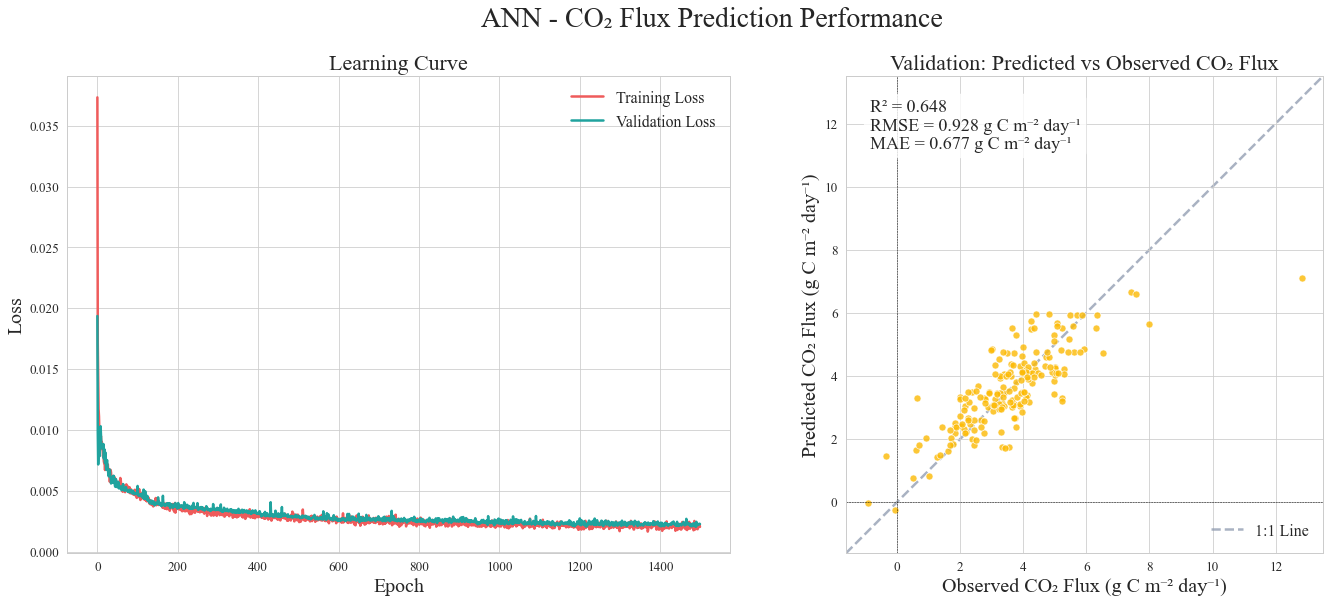

In [11]:
# ------------------------- Plot Training and Validation Results -------------------------
# Validation Scatter plot
model.eval()
val_targets = []
val_predictions = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        val_targets.extend(batch_y.numpy().flatten())
        val_predictions.extend(outputs.numpy().flatten())

val_targets_original = scaler_y.inverse_transform(np.array(val_targets).reshape(-1, 1)).flatten()
val_predictions_original = scaler_y.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

rmse_val = np.sqrt(mean_squared_error(val_targets_original, val_predictions_original))
r2_val = r2_score(val_targets_original, val_predictions_original)
mae_val = np.mean(np.abs(val_targets_original - val_predictions_original))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('ANN - CO₂ Flux Prediction Performance', fontsize=28, y=1.05)

# Learning curve plot
ax1.plot(train_losses, label='Training Loss', color='#ef5b5b')
ax1.plot(val_losses, label='Validation Loss', color='#20a39e')
ax1.set_title('Learning Curve', fontsize=22)
ax1.set_xlabel('Epoch', fontsize=20)
ax1.set_ylabel('Loss', fontsize=20)
ax1.legend(fontsize=16, loc='upper right')
# ax1.set_yscale('log')  # Set y-axis to logarithmic scale

# Scatter plot
scatter = ax2.scatter(val_targets_original, val_predictions_original, 
                      alpha=0.8, c='#fcba04', edgecolors='w', s=50)
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]
ax2.plot(lims, lims, alpha=0.75, zorder=0, label='1:1 Line', color='#8d99ae', linestyle='--')
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_title('Validation: Predicted vs Observed CO₂ Flux', fontsize=22)
ax2.set_xlabel('Observed CO₂ Flux (g C m⁻² day⁻¹)', fontsize=20)
ax2.set_ylabel('Predicted CO₂ Flux (g C m⁻² day⁻¹)', fontsize=20)

# Add zero lines
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Add statistics
stats_text = (
    f'R² = {r2_val:.3f}\n'
    f'RMSE = {rmse_val:.3f} g C m⁻² day⁻¹\n'
    f'MAE = {mae_val:.3f} g C m⁻² day⁻¹'
)
ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
         verticalalignment='top', fontsize=18,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.legend(fontsize=16, loc='lower right')

# Adjust layout and display
plt.tight_layout()
fig.subplots_adjust(top=0.93)

# Save the figure in high resolution
# plt.savefig('co2_flux_prediction_performance.png', dpi=300, bbox_inches='tight')
# plt.savefig('co2_flux_prediction_performance.pdf', bbox_inches='tight')

plt.show()

R-squared (R²): 0.6082
RMSE: 0.8886 g C m⁻² day⁻¹
MAE: 0.6515 g C m⁻² day⁻¹


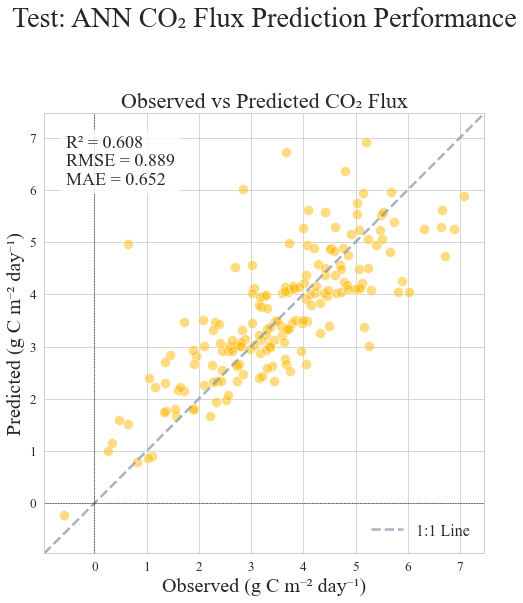

In [10]:
# ------------------------- Testing -------------------------
model.eval()
all_targets, all_predictions = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_targets.extend(batch_y.numpy().flatten())
        all_predictions.extend(outputs.numpy().flatten())

all_targets = scaler_y.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()
all_predictions = scaler_y.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()

r2_ann = r2_score(all_targets, all_predictions)
rmse_ann = np.sqrt(mean_squared_error(all_targets, all_predictions))
mae_ann = np.mean(np.abs(all_targets - all_predictions))

print(f"R-squared (R²): {r2_ann:.4f}")
print(f"RMSE: {rmse_ann:.4f} g C m⁻² day⁻¹")
print(f"MAE: {mae_ann:.4f} g C m⁻² day⁻¹")

# ------------------------- Plot Testing Results -------------------------
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Test: ANN CO₂ Flux Prediction Performance', fontsize=28, y=1.05)

# Scatter plot
ax.scatter(all_targets, all_predictions, alpha=0.5, c='#fcba04', edgecolors='w', s=100)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, alpha=0.75, color='#8d99ae', linestyle='--', label='1:1 Line')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Observed vs Predicted CO₂ Flux', fontsize=22)
ax.set_xlabel('Observed (g C m⁻² day⁻¹)', fontsize=20)
ax.set_ylabel('Predicted (g C m⁻² day⁻¹)', fontsize=20)

# Add zero lines
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Add statistics
stats_text = f'R² = {r2_ann:.3f}\nRMSE = {rmse_ann:.3f}\nMAE = {mae_ann:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
        verticalalignment='top', fontsize=18,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend(fontsize=16, loc='lower right')

plt.tight_layout()
plt.show()

### LSTM Model

In [32]:
# ------------------------- Constants and Hyperparameters -------------------------
BATCH_SIZE = 64
NUM_EPOCHS = 1000
LEARNING_RATE = 0.001
INPUT_SIZE = len(X.columns)  # Set this based on your dataset
OUTPUT_SIZE = 1
SEQ_LENGTH = 30  # Control the length of the sequence
DROP_PROB = 0.6
NUM_LAYERS = 5

# ------------------------- Data Preprocessing -------------------------
# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, seq_length):
    sequences = []
    targets = []
    for i in range(len(X) - seq_length):
        seq = X[i:i+seq_length]
        target = y[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# Shuffle and split the data into training ( %), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------- Model Definition -------------------------
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers= NUM_LAYERS, dropout_prob=DROP_PROB):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.hidden_size = hidden_size
        self.output = nn.Linear(hidden_size, OUTPUT_SIZE)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.relu(self.bn(out))
        out = self.output(out)
        return out

# ------------------------- Initialize Model, Loss Function, Optimizer -------------------------
model = LSTM(INPUT_SIZE)

# Huber loss
criterion = nn.SmoothL1Loss()

# Optimizer
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# ------------------------- Training and Validation -------------------------
train_losses = []
val_losses = []

# Start time
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], "
          f"Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")

# End time
end_time = time.time()
training_time_minutes = (end_time - start_time) / 60
print(f"Training Time: {training_time_minutes:.2f} minutes")


# ------------------------- Plot Training and Validation Results -------------------------
# Validation Scatter plot
model.eval()
val_targets = []
val_predictions = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        val_targets.extend(batch_y.numpy().flatten())
        val_predictions.extend(outputs.numpy().flatten())

val_targets_original = scaler_y.inverse_transform(np.array(val_targets).reshape(-1, 1)).flatten()
val_predictions_original = scaler_y.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

rmse_val = np.sqrt(mean_squared_error(val_targets_original, val_predictions_original))
r2_val = r2_score(val_targets_original, val_predictions_original)
mae_val = np.mean(np.abs(val_targets_original - val_predictions_original))

Epoch [1/1000], Train Loss: 0.0546, Validation Loss: 0.0269
Epoch [2/1000], Train Loss: 0.0184, Validation Loss: 0.0221
Epoch [3/1000], Train Loss: 0.0144, Validation Loss: 0.0210
Epoch [4/1000], Train Loss: 0.0117, Validation Loss: 0.0285
Epoch [5/1000], Train Loss: 0.0116, Validation Loss: 0.0218
Epoch [6/1000], Train Loss: 0.0110, Validation Loss: 0.0267
Epoch [7/1000], Train Loss: 0.0109, Validation Loss: 0.0301
Epoch [8/1000], Train Loss: 0.0106, Validation Loss: 0.0194
Epoch [9/1000], Train Loss: 0.0089, Validation Loss: 0.0198
Epoch [10/1000], Train Loss: 0.0083, Validation Loss: 0.0312
Epoch [11/1000], Train Loss: 0.0083, Validation Loss: 0.0310
Epoch [12/1000], Train Loss: 0.0083, Validation Loss: 0.0126
Epoch [13/1000], Train Loss: 0.0091, Validation Loss: 0.0305
Epoch [14/1000], Train Loss: 0.0083, Validation Loss: 0.0146
Epoch [15/1000], Train Loss: 0.0086, Validation Loss: 0.0167
Epoch [16/1000], Train Loss: 0.0078, Validation Loss: 0.0149
Epoch [17/1000], Train Loss: 0.00

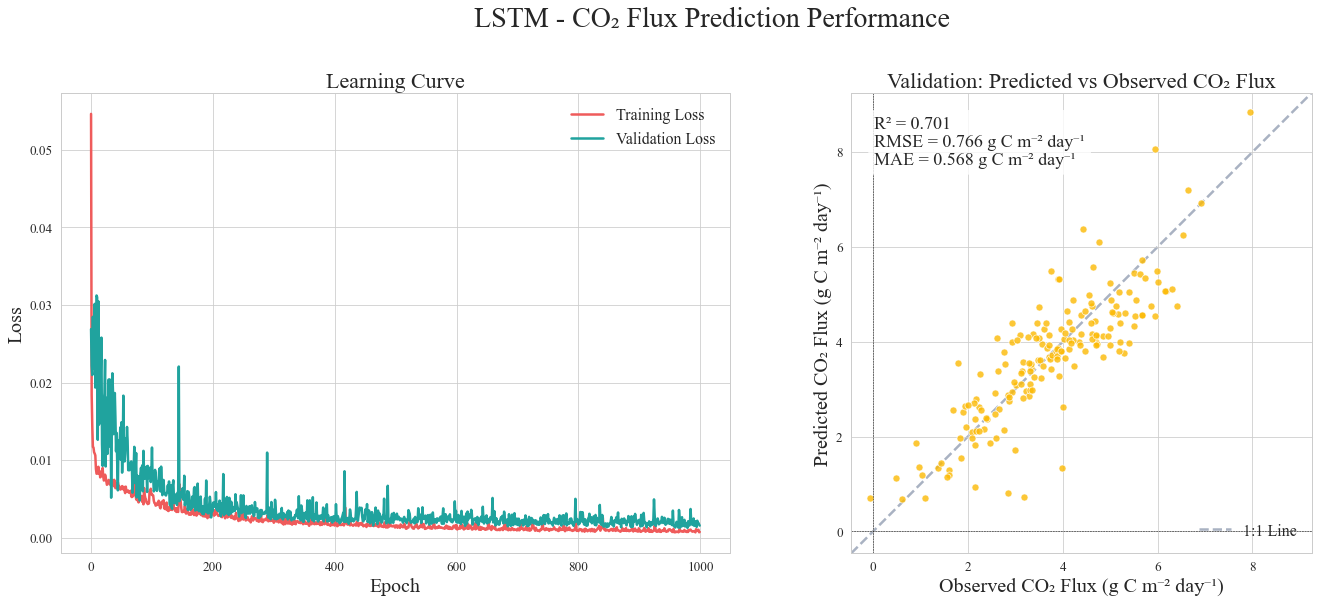

In [33]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('LSTM - CO₂ Flux Prediction Performance', fontsize=28, y=1.05)

# Learning curve plot
ax1.plot(train_losses, label='Training Loss', color='#ef5b5b')
ax1.plot(val_losses, label='Validation Loss', color='#20a39e')
ax1.set_title('Learning Curve', fontsize=22)
ax1.set_xlabel('Epoch', fontsize=20)
ax1.set_ylabel('Loss', fontsize=20)
ax1.legend(fontsize=16, loc='upper right')
# ax1.set_yscale('log')  # Set y-axis to logarithmic scale

# Scatter plot
ax2.scatter(val_targets_original, val_predictions_original, alpha=0.8, c='#fcba04', edgecolors='w', s=50)
lims = [min(ax2.get_xlim()[0], ax2.get_ylim()[0]), max(ax2.get_xlim()[1], ax2.get_ylim()[1])]
ax2.plot(lims, lims, alpha=0.75, zorder=0, label='1:1 Line', color='#8d99ae', linestyle='--')
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_title('Validation: Predicted vs Observed CO₂ Flux', fontsize=22)
ax2.set_xlabel('Observed CO₂ Flux (g C m⁻² day⁻¹)', fontsize=20)
ax2.set_ylabel('Predicted CO₂ Flux (g C m⁻² day⁻¹)', fontsize=20)

# Add zero lines
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Add statistics
stats_text = (
    f'R² = {r2_val:.3f}\n'
    f'RMSE = {rmse_val:.3f} g C m⁻² day⁻¹\n'
    f'MAE = {mae_val:.3f} g C m⁻² day⁻¹'
)
ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes,
         verticalalignment='top', fontsize=18,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.legend(fontsize=16, loc='lower right')

# Adjust layout and display
plt.tight_layout()
fig.subplots_adjust(top=0.9)

# Save the figure in high resolution
# plt.savefig('co2_flux_prediction_performance.png', dpi=300, bbox_inches='tight')
# plt.savefig('co2_flux_prediction_performance.pdf', bbox_inches='tight')

plt.show()

R-squared (R²): 0.6963
RMSE: 0.8349 g C m⁻² day⁻¹
MAE: 0.5985 g C m⁻² day⁻¹


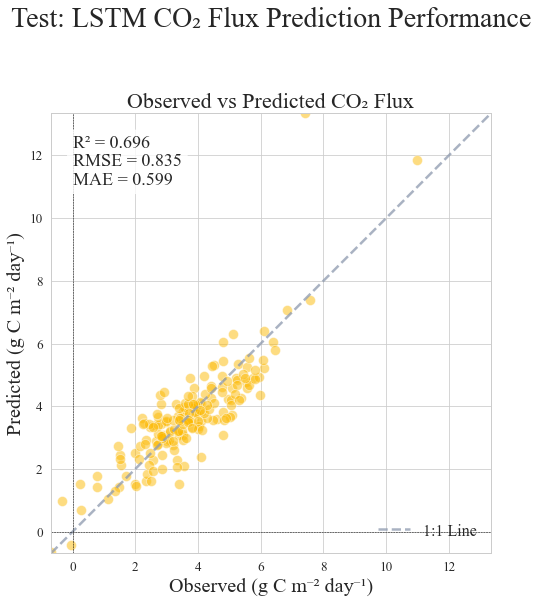

In [34]:
# ------------------------- Testing -------------------------
model.eval()
all_targets, all_predictions = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_targets.extend(batch_y.numpy().flatten())
        all_predictions.extend(outputs.numpy().flatten())

all_targets_original = scaler_y.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()
all_predictions_original = scaler_y.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()

r2_lstm = r2_score(all_targets_original, all_predictions_original)
rmse_lstm = np.sqrt(mean_squared_error(all_targets_original, all_predictions_original))
mae_lstm = np.mean(np.abs(all_targets_original - all_predictions_original))

print(f"R-squared (R²): {r2_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f} g C m⁻² day⁻¹")
print(f"MAE: {mae_lstm:.4f} g C m⁻² day⁻¹")

# ------------------------- Plot Testing Results -------------------------
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Test: LSTM CO₂ Flux Prediction Performance', fontsize=28, y=1.05)

# Scatter plot
ax.scatter(all_targets_original, all_predictions_original, alpha=0.5, c='#fcba04', edgecolors='w', s=100)
lims = [min(all_targets_original.min(), all_predictions_original.min()), 
        max(all_targets_original.max(), all_predictions_original.max())]
ax.plot(lims, lims, alpha=0.75, color='#8d99ae', linestyle='--', label='1:1 Line')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Observed vs Predicted CO₂ Flux', fontsize=22)
ax.set_xlabel('Observed (g C m⁻² day⁻¹)', fontsize=20)
ax.set_ylabel('Predicted (g C m⁻² day⁻¹)', fontsize=20)

# Add zero lines
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Add statistics
stats_text = f'R² = {r2_lstm:.3f}\nRMSE = {rmse_lstm:.3f}\nMAE = {mae_lstm:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
        verticalalignment='top', fontsize=18,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend(fontsize=16, loc='lower right')

plt.tight_layout()
plt.show()
